# Brain tumor segmentation from MRI

## 1)Importing all the necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

from datetime import datetime

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

## 2) Reading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/"

In [ ]:
# data = pd.read_csv(BASE_PATH+'kaggle_3m/data.csv')
# data.info()

NameError: ignored

In [ ]:
# data.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

In [ ]:
# t=glob.glob(BASE_PATH+"kaggle_3m/"+"*")[-1]
# t

'/content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/kaggle_3m/TCGA_FG_A60K_20040224'

In [ ]:
# data_map = []
# for sub_dir_path in glob.glob(BASE_PATH+"kaggle_3m/"+"*"):
#     #if os.path.isdir(sub_path_dir):
#     try:
#         dir_name = sub_dir_path.split('/')[-1]
#         for filename in os.listdir(sub_dir_path):
#             image_path = sub_dir_path + '/' + filename
#             data_map.extend([dir_name, image_path])
#     except Exception as e:
#         print(e)

[Errno 20] Not a directory: '/content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/kaggle_3m/data.csv'


In [ ]:
# df = pd.DataFrame({"patient_id" : data_map[::2],
#                    "path" : data_map[1::2]})
# df.head()

patient_id                                               path
0  TCGA_DU_8168_19970503  /content/drive/MyDrive/Dissertation/Medical_Im...
1  TCGA_DU_8168_19970503  /content/drive/MyDrive/Dissertation/Medical_Im...
2  TCGA_DU_8168_19970503  /content/drive/MyDrive/Dissertation/Medical_Im...
3  TCGA_DU_8168_19970503  /content/drive/MyDrive/Dissertation/Medical_Im...
4  TCGA_DU_8168_19970503  /content/drive/MyDrive/Dissertation/Medical_Im...

In [ ]:
# df_imgs = df[~df['path'].str.contains("mask")]
# df_masks = df[df['path'].str.contains("mask")]

# # File path line length images for later sorting
# BASE_LEN = 136 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
# END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
# END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# # Data sorting
# imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
# masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# # Sorting check
# idx = random.randint(0, len(imgs)-1)
# print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_36.tif 
Path to the Mask: /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_36_mask.tif


In [ ]:
# # Final dataframe
# brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
#                          "image_path": imgs,
#                          "mask_path": masks
#                         })

In [ ]:
# import pandas as pd

# # Load your original DataFrame (replace this with your actual data)
# # df = pd.read_csv("your_dataframe.csv")

# # Set the desired number of samples
# num_samples = 1200  # Adjust as needed

# # Randomly subsample the DataFrame
# subsampled_df = brain_df.sample(n=num_samples, random_state=42)  # You can change the random_state value

# # Display the subsampled DataFrame
# subsampled_df.shape

(1200, 3)

In [ ]:
# subsampled_df.head()

patient_id  \
1835  TCGA_FG_7643_20021104   
1490  TCGA_FG_6690_20020226   
2063  TCGA_DU_7019_19940908   
1178  TCGA_FG_8189_20030516   
3749  TCGA_EZ_7264_20010816   

                                             image_path  \
1835  /content/drive/MyDrive/Dissertation/Medical_Im...   
1490  /content/drive/MyDrive/Dissertation/Medical_Im...   
2063  /content/drive/MyDrive/Dissertation/Medical_Im...   
1178  /content/drive/MyDrive/Dissertation/Medical_Im...   
3749  /content/drive/MyDrive/Dissertation/Medical_Im...   

                                              mask_path  
1835  /content/drive/MyDrive/Dissertation/Medical_Im...  
1490  /content/drive/MyDrive/Dissertation/Medical_Im...  
2063  /content/drive/MyDrive/Dissertation/Medical_Im...  
1178  /content/drive/MyDrive/Dissertation/Medical_Im...  
3749  /content/drive/MyDrive/Dissertation/Medical_Im...

In [ ]:
# output_file = BASE_PATH + 'brain_sample.csv'  # Replace with your desired file path
# subsampled_df.to_csv(output_file, index=False)

In [ ]:
# output_file = BASE_PATH + 'brain_dataframe.csv'  # Replace with your desired file path
# brain_df.to_csv(output_file, index=False)

In [ ]:
# subsampled_df = pd.read_csv(BASE_PATH + "brain_sample.csv")

In [ ]:
# subsampled_df.head()

patient_id                                         image_path  \
0  TCGA_FG_7643_20021104  /content/drive/MyDrive/Dissertation/Medical_Im...   
1  TCGA_FG_6690_20020226  /content/drive/MyDrive/Dissertation/Medical_Im...   
2  TCGA_DU_7019_19940908  /content/drive/MyDrive/Dissertation/Medical_Im...   
3  TCGA_FG_8189_20030516  /content/drive/MyDrive/Dissertation/Medical_Im...   
4  TCGA_EZ_7264_20010816  /content/drive/MyDrive/Dissertation/Medical_Im...   

                                           mask_path  
0  /content/drive/MyDrive/Dissertation/Medical_Im...  
1  /content/drive/MyDrive/Dissertation/Medical_Im...  
2  /content/drive/MyDrive/Dissertation/Medical_Im...  
3  /content/drive/MyDrive/Dissertation/Medical_Im...  
4  /content/drive/MyDrive/Dissertation/Medical_Im...

In [ ]:
# def pos_neg_diagnosis(mask_path):
#     value = np.max(cv2.imread(mask_path))
#     if value > 0 :
#         return 1
#     else:
#         return 0

# subsampled_df['mask'] = subsampled_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
# subsampled_df.head()

patient_id                                         image_path  \
0  TCGA_FG_7643_20021104  /content/drive/MyDrive/Dissertation/Medical_Im...   
1  TCGA_FG_6690_20020226  /content/drive/MyDrive/Dissertation/Medical_Im...   
2  TCGA_DU_7019_19940908  /content/drive/MyDrive/Dissertation/Medical_Im...   
3  TCGA_FG_8189_20030516  /content/drive/MyDrive/Dissertation/Medical_Im...   
4  TCGA_EZ_7264_20010816  /content/drive/MyDrive/Dissertation/Medical_Im...   

                                           mask_path  mask  
0  /content/drive/MyDrive/Dissertation/Medical_Im...     1  
1  /content/drive/MyDrive/Dissertation/Medical_Im...     1  
2  /content/drive/MyDrive/Dissertation/Medical_Im...     1  
3  /content/drive/MyDrive/Dissertation/Medical_Im...     1  
4  /content/drive/MyDrive/Dissertation/Medical_Im...     0

In [ ]:
# subsampled_df['mask'].value_counts()

0    780
1    420
Name: mask, dtype: int64

## 3) Visualize the dataset

In [ ]:
# import plotly.graph_objects as go  # using plotly to create interactive plots

# fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index,
#                         y=brain_df['mask'].value_counts(),
#                         width=[.4, .4]
#                        )
#                 ])
# fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
#                   marker_line_width=4, opacity=0.4
#                  )
# fig.update_layout(title_text="Mask Count Plot",
#                   width=700,
#                   height=550,
#                   yaxis=dict(
#                              title_text="Count",
#                              tickmode="array",
#                              titlefont=dict(size=20)
#                            )
#                  )
# fig.update_yaxes(automargin=True)
# fig.show()

In [ ]:
# # whole_df = brain_df
# brain_df = subsampled_df

In [ ]:
# cv2.imread(brain_df.mask_path.iloc[0]).max()


255

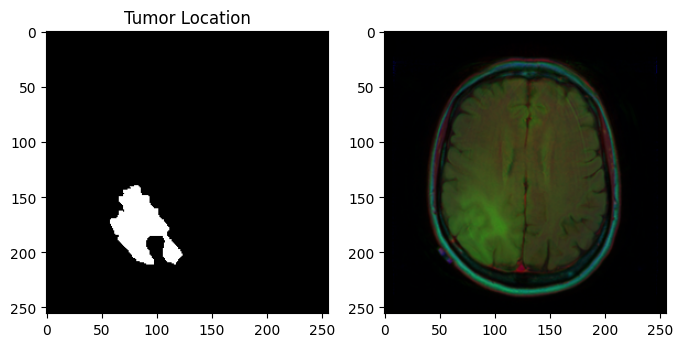

In [ ]:
# for i in range(len(brain_df)):
#     if cv2.imread(brain_df['mask_path'].iloc[i]).max() > 0:
#         break

# plt.figure(figsize=(8,8))
# plt.subplot(1,2,1)
# plt.imshow(cv2.imread(brain_df.mask_path.iloc[i]));
# plt.title('Tumor Location')

# plt.subplot(1,2,2)
# plt.imshow(cv2.imread(brain_df.image_path.iloc[i]));

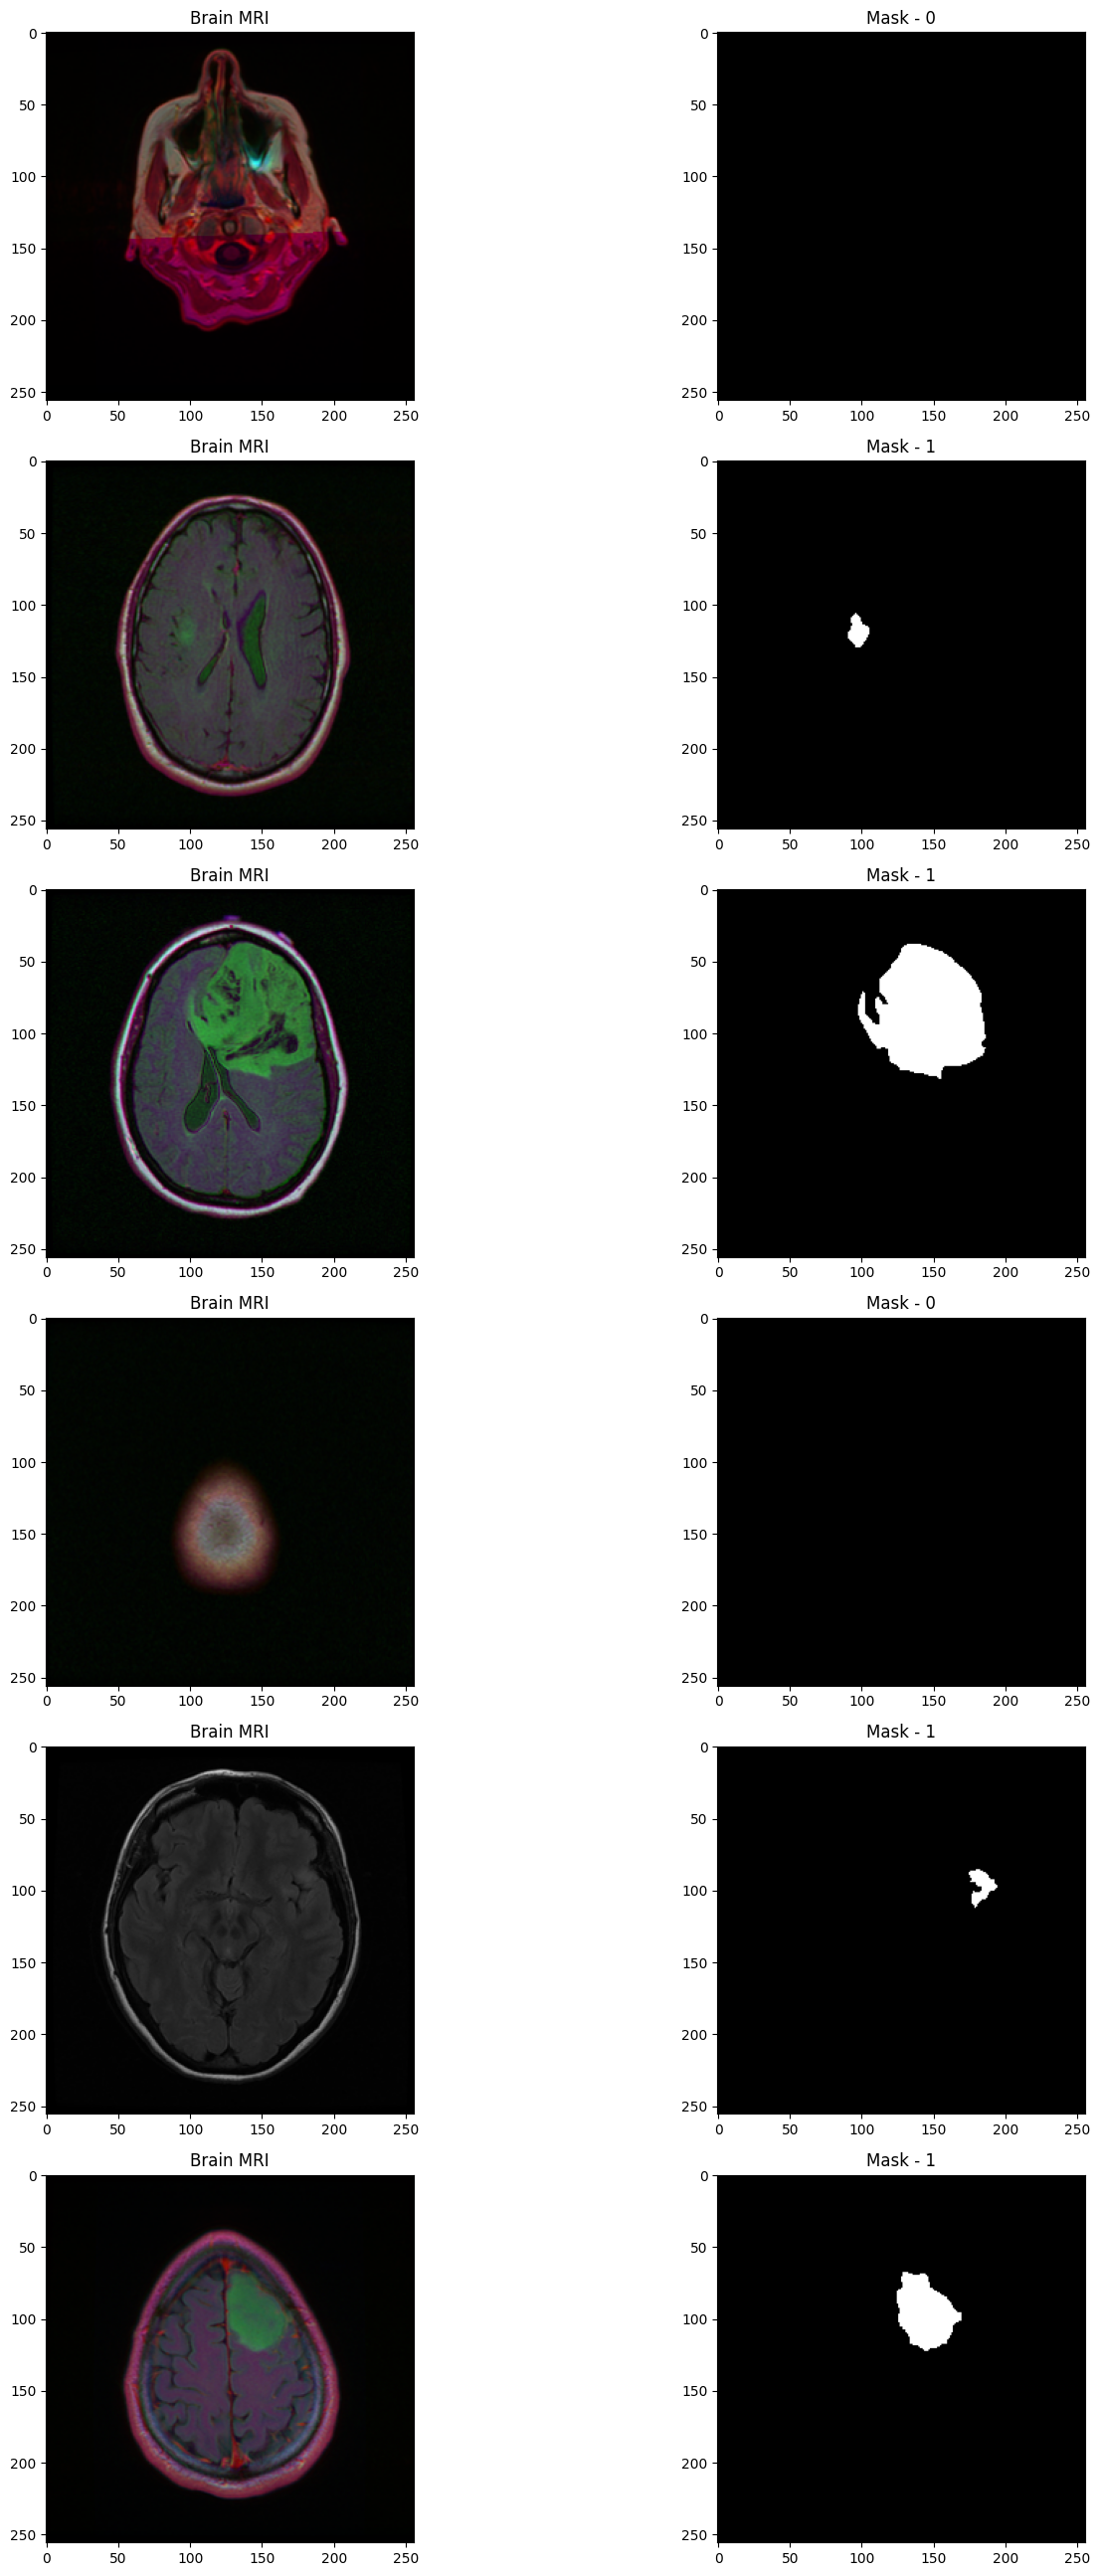

In [ ]:
# # Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately

# fig, axs = plt.subplots(6,2, figsize=(16,26))
# count = 0
# for x in range(6):
#   i = random.randint(0, len(brain_df)) # select a random index
#   axs[count][0].title.set_text("Brain MRI") # set title
#   axs[count][0].imshow(cv2.imread(brain_df.image_path.iloc[i])) # show MRI
#   axs[count][1].title.set_text("Mask - " + str(brain_df['mask'].iloc[i])) # plot title on the mask (0 or 1)
#   axs[count][1].imshow(cv2.imread(brain_df.mask_path.iloc[i])) # Show corresponding mask
#   count += 1

# fig.tight_layout()

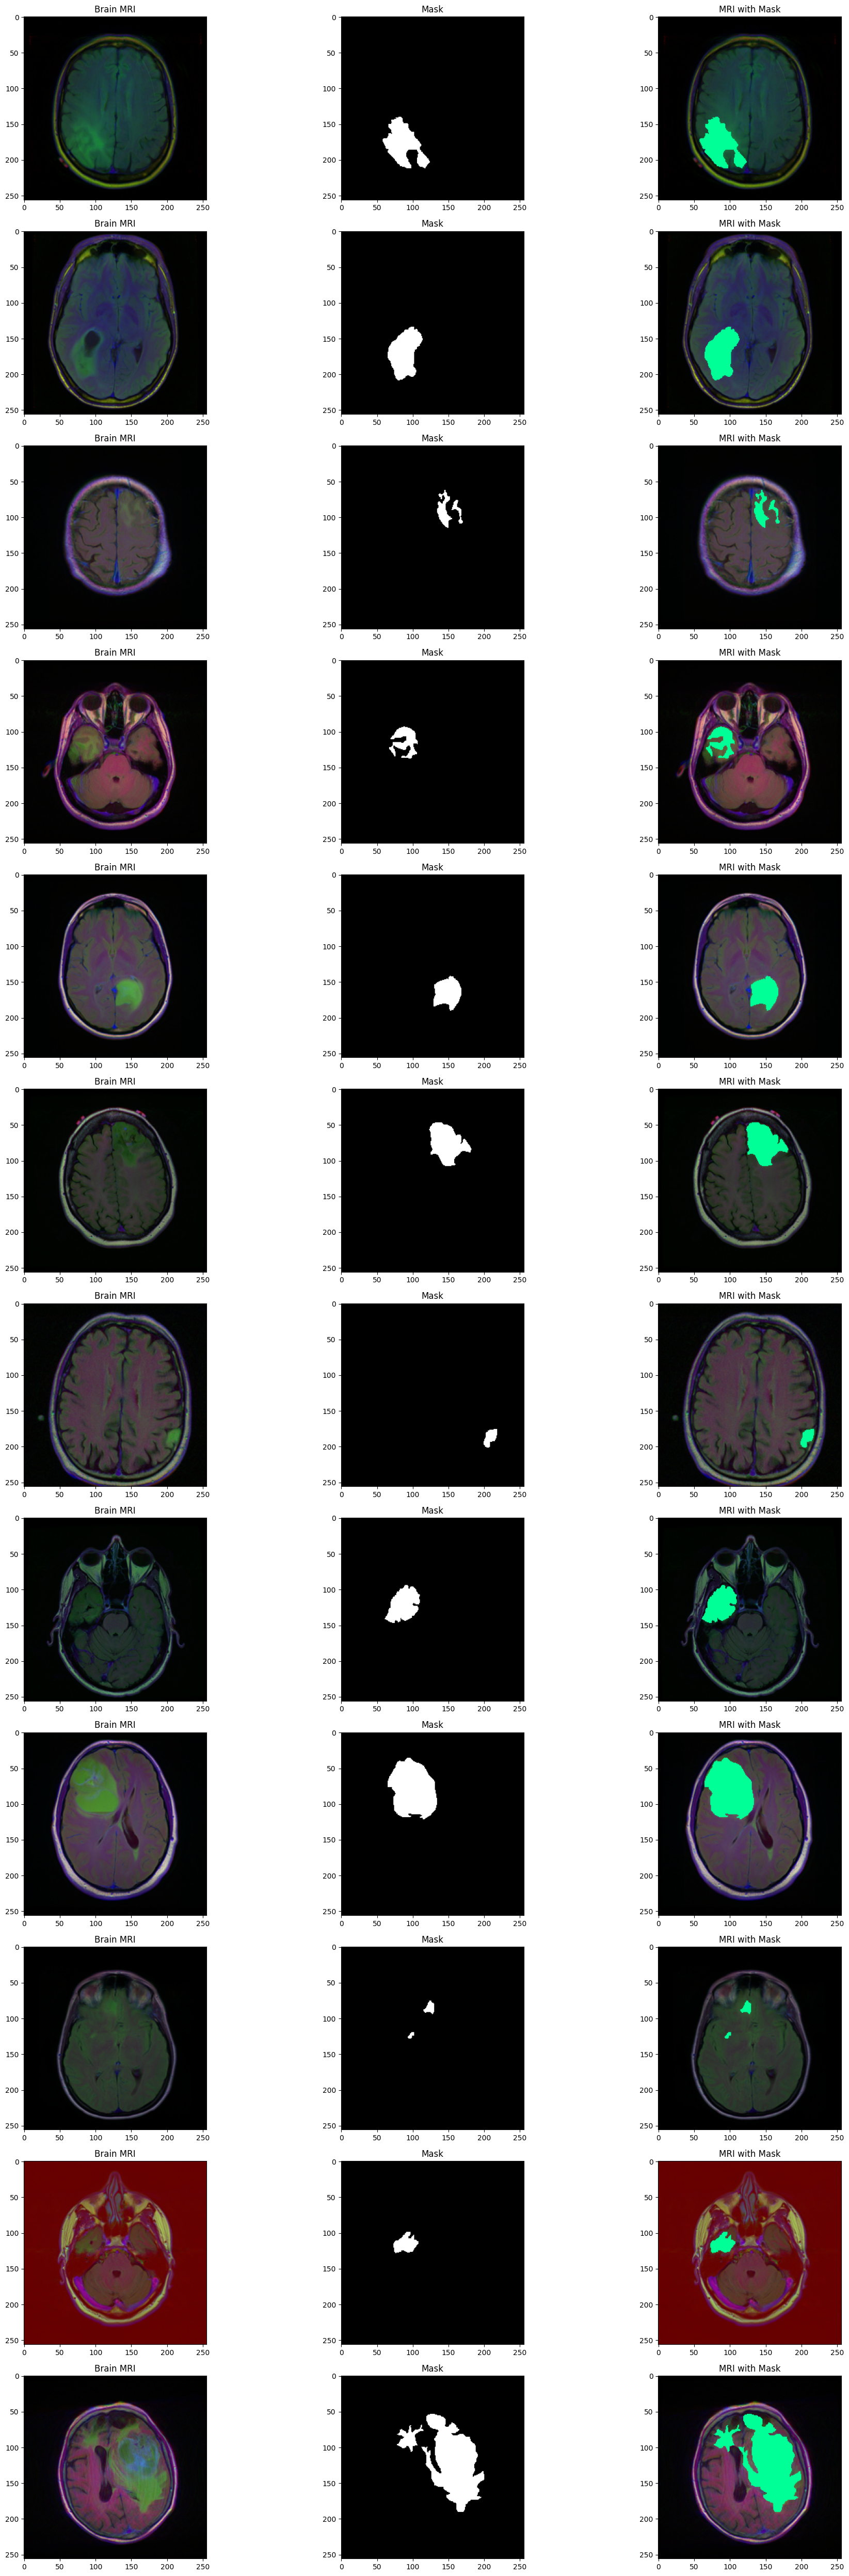

In [ ]:
# count = 0
# i = 0
# fig,axs = plt.subplots(12,3, figsize=(20,50))
# for mask in brain_df['mask']:
#     if (mask==1):
#         img = io.imread(brain_df.image_path.iloc[i])
#         axs[count][0].title.set_text("Brain MRI")
#         axs[count][0].imshow(img)

#         mask = io.imread(brain_df.mask_path.iloc[i])
#         axs[count][1].title.set_text("Mask")
#         axs[count][1].imshow(mask, cmap='gray')

#         img[mask==255] = (0,255,150)  # change pixel color at the position of mask
#         axs[count][2].title.set_text("MRI with Mask")
#         axs[count][2].imshow(img)
#         count +=1
#     i += 1
#     if (count==12):
#         break

# fig.tight_layout()

In [ ]:
# brain_df_train = brain_df.drop(columns=['patient_id'])
# # Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
# brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1200 non-null   object
 1   mask_path   1200 non-null   object
 2   mask        1200 non-null   object
dtypes: object(3)
memory usage: 28.2+ KB


In [ ]:
# brain_df_mask = brain_df[brain_df['mask'] == 1]
# brain_df_mask.shape

(420, 4)

In [ ]:
# brain_df_mask.to_csv(BASE_PATH+"brain_final.csv")

In [ ]:
brain_df_mask = pd.read_csv(BASE_PATH + "brain_final.csv")
brain_df_mask.head()

Unnamed: 0             patient_id  \
0           0  TCGA_FG_7643_20021104   
1           1  TCGA_FG_6690_20020226   
2           2  TCGA_DU_7019_19940908   
3           3  TCGA_FG_8189_20030516   
4           9  TCGA_CS_6186_20000601   

                                          image_path  \
0  /content/drive/MyDrive/Dissertation/Medical_Im...   
1  /content/drive/MyDrive/Dissertation/Medical_Im...   
2  /content/drive/MyDrive/Dissertation/Medical_Im...   
3  /content/drive/MyDrive/Dissertation/Medical_Im...   
4  /content/drive/MyDrive/Dissertation/Medical_Im...   

                                           mask_path  mask  
0  /content/drive/MyDrive/Dissertation/Medical_Im...     1  
1  /content/drive/MyDrive/Dissertation/Medical_Im...     1  
2  /content/drive/MyDrive/Dissertation/Medical_Im...     1  
3  /content/drive/MyDrive/Dissertation/Medical_Im...     1  
4  /content/drive/MyDrive/Dissertation/Medical_Im...     1

## 4) Dvidie the datset into training, test and validation

In [ ]:
from sklearn.model_selection import train_test_split

# train, test = train_test_split(brain_df_train, test_size=0.15)

In [ ]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.2)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 336, valid size is 42 & test size is 42


In [ ]:
test

## 5) Use DataGenerator to load images

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 8, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'

    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth)
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])

      #mask path
      mask_path = str(list_mask[i])

      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)

      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising
      img -= img.mean()
      img /= img.std()

      mask -= mask.mean()
      mask /= mask.std()

      #Adding image to the empty array
      X[i,] = img

      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)

    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

## Define Models

### Loss functions

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### Useful Block functions

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # Repeats the elements of a tensor along an axis by a factor of rep.
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(
        inter_shape,
        (3, 3),
        strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
        padding='same')(phi_g)

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(
        size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


### Define Model Architecture

In [ ]:
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

def Res_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Res-UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


In [ ]:
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
# save the best model with lower validation loss
unet_checkpointer = ModelCheckpoint(filepath=BASE_PATH+"Unet-raw-checkpoint.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
# save the best model with lower validation loss
res_unet_checkpointer = ModelCheckpoint(filepath=BASE_PATH+"Res-Unet-checkpoint.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
# save the best model with lower validation loss
att_res_unet_checkpointer = ModelCheckpoint(filepath=BASE_PATH+"Att-Res-Unet-checkpoint.hdf5",
                               verbose=1,
                               save_best_only=True
                              )

### Train Models

In [ ]:
!pip install focal_loss

In [ ]:
from focal_loss import BinaryFocalLoss

In [ ]:
input_shape = (256, 256, 3)

UNET

In [ ]:
unet_model = UNet(input_shape)
unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy', jacard_coef])


print(unet_model.summary())

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

None
Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [ ]:
start1 = datetime.now()
unet_history = unet_model.fit(train_data,
                    verbose=1,
                    validation_data=val_data,
                    shuffle=False,
                    callbacks = [unet_checkpointer, earlystopping, reduce_lr],
                    epochs=100)

stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.7448 - jacard_coef: 0.0443
Epoch 1: val_loss improved from inf to 15.59905, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/Unet-raw-checkpoint.hdf5
42/42 [==============================] - 458s 10s/step - loss: 0.1719 - accuracy: 0.7448 - jacard_coef: 0.0443 - val_loss: 15.5991 - val_accuracy: 0.0254 - val_jacard_coef: 0.0254 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9590 - jacard_coef: 0.0439
Epoch 2: val_loss improved from 15.59905 to 0.22008, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/Unet-raw-checkpoint.hdf5
42/42 [==============================] - 27s 637ms/step - loss: 0.1417 - accuracy: 0.9590 - jacard_coef: 0.0439 - val_loss: 0.2201 - val_accuracy: 0.8588 - val_jacard_coef: 0.0525 - lr: 0.0010
Epoch 3/100
42/42 [=============

In [ ]:
unet_model.save(BASE_PATH + 'UNet_100epochs_B_focal.hdf5')

Res-UNET

In [ ]:
res_unet_model = Res_UNet(input_shape)
res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy', jacard_coef])


print(res_unet_model.summary())

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                              

None
Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                         

In [ ]:
start2 = datetime.now()
res_unet_history = res_unet_model.fit(train_data,
                    verbose=1,
                    validation_data=val_data,
                    shuffle=False,
                    callbacks = [res_unet_checkpointer, earlystopping, reduce_lr],
                    epochs=100)

stop2 = datetime.now()
#Execution time of the model
execution_time_Res_Unet = stop2-start2
print("Res-UNet execution time is: ", execution_time_Res_Unet)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.8315 - jacard_coef: 0.0450
Epoch 1: val_loss improved from inf to 2.69947, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/Res-Unet-checkpoint.hdf5
42/42 [==============================] - 51s 674ms/step - loss: 0.1637 - accuracy: 0.8315 - jacard_coef: 0.0450 - val_loss: 2.6995 - val_accuracy: 0.7142 - val_jacard_coef: 0.0235 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9553 - jacard_coef: 0.0445
Epoch 2: val_loss did not improve from 2.69947
42/42 [==============================] - 26s 623ms/step - loss: 0.1412 - accuracy: 0.9553 - jacard_coef: 0.0445 - val_loss: 9.1101 - val_accuracy: 0.1027 - val_jacard_coef: 0.0250 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9682 - jacard_coef: 0.0463
Epoch 3: val_loss improved from 2.69947 to 0.

In [ ]:
res_unet_model.save(BASE_PATH + 'Res_UNet_100epochs_B_focal.hdf5')

Attention Res-UNet

In [ ]:
att_res_unet_model = Attention_ResUNet(input_shape)
att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy', jacard_coef])


print(att_res_unet_model.summary())

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_47 (BatchN  (None, 256, 256, 64  256        ['conv2d_47[0][0]']              
 ormalization)                  )                                                  

In [ ]:
start3 = datetime.now()
att_res_unet_history = att_res_unet_model.fit(train_data,
                    verbose=1,
                    validation_data=val_data,
                    shuffle=False,
                    callbacks = [att_res_unet_checkpointer, earlystopping, reduce_lr],
                    epochs=100)

stop3 = datetime.now()
#Execution time of the model
execution_time_Res_Unet = stop3-start3
print("Res-UNet execution time is: ", execution_time_Res_Unet)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9094 - jacard_coef: 0.0442
Epoch 1: val_loss improved from inf to 2.16864, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/Att-Res-Unet-checkpoint.hdf5
42/42 [==============================] - 73s 872ms/step - loss: 0.1703 - accuracy: 0.9094 - jacard_coef: 0.0442 - val_loss: 2.1686 - val_accuracy: 0.2553 - val_jacard_coef: 0.0343 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.9635 - jacard_coef: 0.0441
Epoch 2: val_loss improved from 2.16864 to 1.29429, saving model to /content/drive/MyDrive/Dissertation/Medical_Image_Segmentation/Datasets/Brain_MRI/Att-Res-Unet-checkpoint.hdf5
42/42 [==============================] - 38s 906ms/step - loss: 0.1371 - accuracy: 0.9635 - jacard_coef: 0.0441 - val_loss: 1.2943 - val_accuracy: 0.3462 - val_jacard_coef: 0.0297 - lr: 0.0010
Epoch 3/100
42/42 [=======

In [ ]:
att_res_unet_model.save(BASE_PATH + 'Att_Res_UNet_100epochs_B_focal.hdf5')

Save history files as Dataframe

In [ ]:
import pandas as pd
unet_history_df = pd.DataFrame(unet_history.history)
res_unet_history_df = pd.DataFrame(res_unet_history.history)
att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history)

with open(BASE_PATH+'unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)

with open(BASE_PATH+'res_unet_history_df.csv', mode='w') as f:
    res_unet_history_df.to_csv(f)

with open(BASE_PATH+'att_res_unet_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f)

NameError: ignored

## Load Model and history for Evaluation and Visualisation

In [ ]:
from pandas.core.generic import indexing
unet_history_df = pd.read_csv(BASE_PATH + 'unet_history_df.csv')
res_unet_history_df = pd.read_csv(BASE_PATH + 'res_unet_history_df.csv')
att_res_unet_history_df = pd.read_csv(BASE_PATH + 'att_res_unet_history_df.csv')

In [ ]:
unet_model = tf.keras.models.load_model(BASE_PATH + 'UNet_100epochs_B_focal.hdf5',custom_objects={'jacard_coef': jacard_coef})
res_unet_model = tf.keras.models.load_model(BASE_PATH + 'Res_UNet_100epochs_B_focal.hdf5', custom_objects={'jacard_coef': jacard_coef})
att_res_unet_model = tf.keras.models.load_model(BASE_PATH + 'Att_Res_UNet_100epochs_B_focal.hdf5', custom_objects={'jacard_coef': jacard_coef})

In [ ]:
unet_history_df.head()

Unnamed: 0      loss  accuracy  jacard_coef   val_loss  val_accuracy  \
0           0  0.171900  0.744790     0.044328  15.599052      0.025355   
1           1  0.141685  0.959032     0.043858   0.220078      0.858804   
2           2  0.131454  0.954000     0.043956   0.655001      0.424424   
3           3  0.120927  0.966458     0.045192   0.118350      0.979980   
4           4  0.115002  0.967243     0.044403   0.222190      0.493772   

   val_jacard_coef     lr  
0         0.025356  0.001  
1         0.052536  0.001  
2         0.032443  0.001  
3         0.028351  0.001  
4         0.024609  0.001

In [ ]:
max(unet_history_df.val_jacard_coef)

0.0793362706899643

In [ ]:
min(unet_history_df.val_loss)

0.0165672227740287

## 8) Visualizing the metrics of model of our model

###UNET

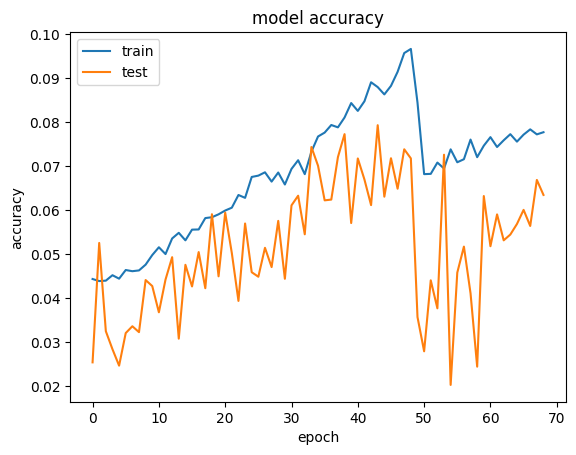

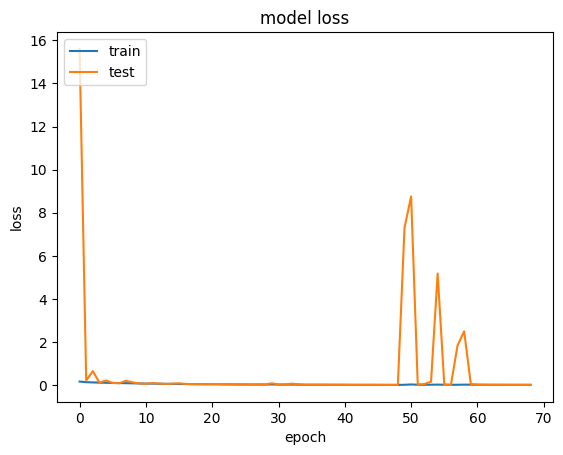

In [ ]:
# summarize history for accuracy
plt.plot(unet_history_df['jacard_coef'])
plt.plot(unet_history_df['val_jacard_coef'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(unet_history_df['loss'])
plt.plot(unet_history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Res-UNET

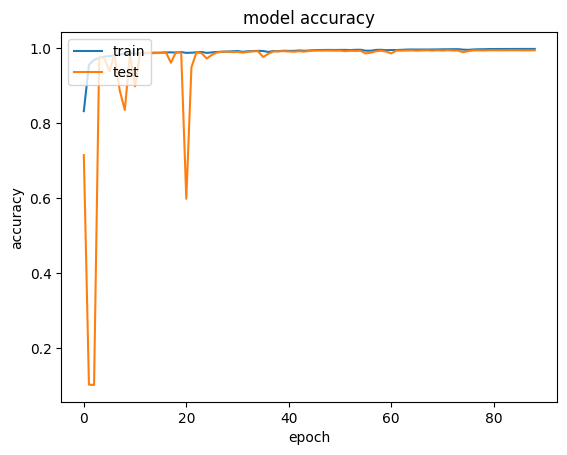

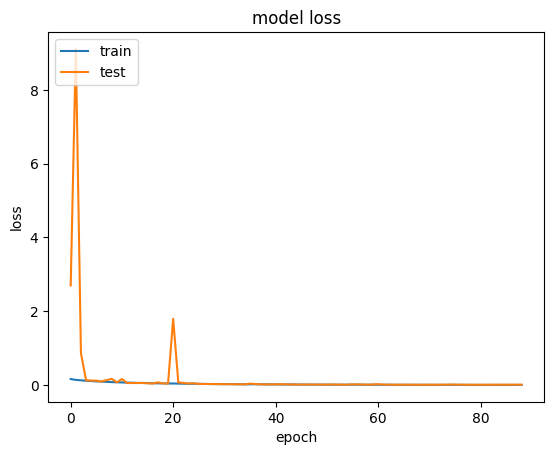

In [ ]:
# summarize history for accuracy
plt.plot(res_unet_history_df['accuracy'])
plt.plot(res_unet_history_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(res_unet_history_df['loss'])
plt.plot(res_unet_history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Att-Res-UNET

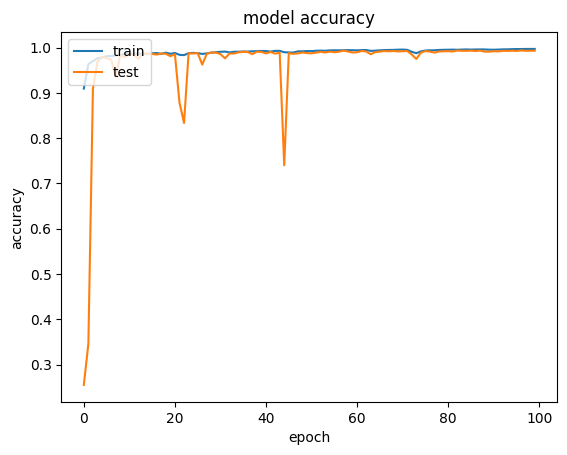

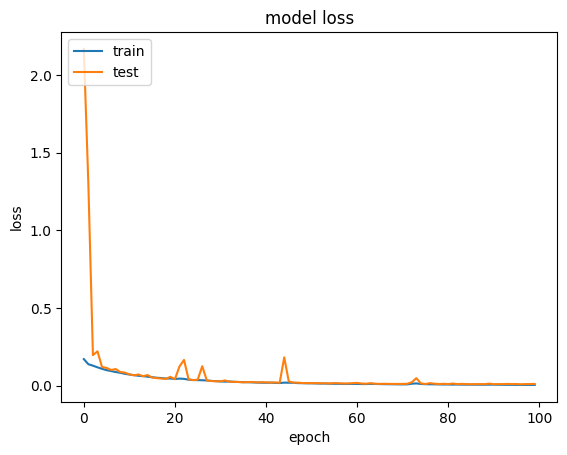

In [ ]:
# summarize history for accuracy
plt.plot(att_res_unet_history_df['accuracy'])
plt.plot(att_res_unet_history_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(att_res_unet_history_df['loss'])
plt.plot(att_res_unet_history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Together

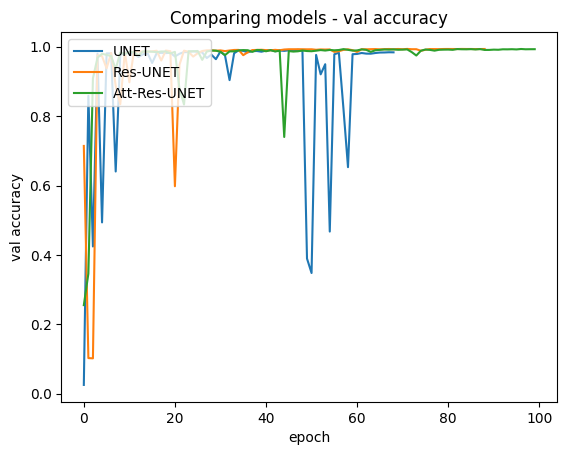

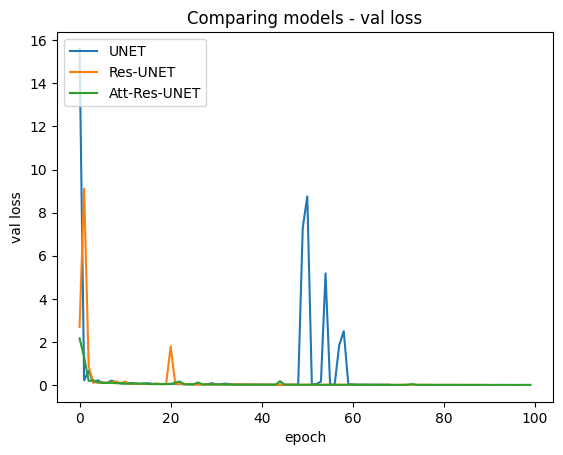

In [ ]:
# summarize history for accuracy
plt.plot(unet_history_df['val_accuracy'])
plt.plot(res_unet_history_df['val_accuracy'])
plt.plot(att_res_unet_history_df['val_accuracy'])

plt.title('Comparing models - val accuracy')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend(['UNET', 'Res-UNET', 'Att-Res-UNET'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(unet_history_df['val_loss'])
plt.plot(res_unet_history_df['val_loss'])
plt.plot(att_res_unet_history_df['val_loss'])

plt.title('Comparing models - val loss')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['UNET', 'Res-UNET', 'Att-Res-UNET'], loc='upper left')
plt.show()

## Quantitative tests

Get dataset

In [ ]:
def get_dataset(data):
  X = np.empty((len(data), 256, 256, 3))
  y = np.empty((len(data), 256, 256, 1))
  i = 0
  for index, row in data.iterrows():
      # Load the image
      img_path = row['image_path']
      img = io.imread(img_path)
      img = cv2.resize(img, (256, 256))
      img = np.array(img, dtype=np.float64)
      img -= img.mean()
      img /= img.std()

      # Load the original mask
      orig_mask_path = row['mask_path']
      orig_mask = io.imread(orig_mask_path)
      orig_mask = cv2.resize(orig_mask, (256, 256))
      orig_mask = np.array(orig_mask, dtype=np.float64)
      orig_mask -= orig_mask.mean()
      orig_mask /= orig_mask.std()

      #Adding image to the empty array
      X[i,] = img
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(orig_mask, axis = 2)

      # print("appending image:", i)
      i += 1

  y = (y > 0).astype(int)
  return X, y



In [ ]:
X_arr, y_arr = get_dataset(X_test)

Evaluation Metric Functions

In [ ]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def cal_accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def cal_dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

Display Functions

In [ ]:
!pip install tabulate

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tabulate import tabulate

def create_blue_cmap():
    blue = sns.color_palette("Blues", as_cmap=True)
    colors = blue(np.linspace(0, 1, 256))
    return LinearSegmentedColormap.from_list("custom_blue", colors)

def create_red_cmap():
    red = sns.color_palette("Reds", as_cmap=True)
    colors = red(np.linspace(0, 1, 256))
    return LinearSegmentedColormap.from_list("custom_red", colors)

def display_confusion_matrix(Y_val, Y_pred):
    FP = len(np.where(Y_pred - Y_val == 1)[0])
    FN = len(np.where(Y_pred - Y_val == -1)[0])
    TP = len(np.where(Y_pred + Y_val == 2)[0])
    TN = len(np.where(Y_pred + Y_val == 0)[0])
    print("TN: ", TN, "FP: ", FP)
    print("FN: ", FN, "TP: ", TP)
    # cmat = [[FP, TN], [TP, FN]]
    cmat = [[TN, FP], [FN, TP]]

    plt.figure(figsize=(6, 6))
    sns.heatmap(cmat, cmap=ListedColormap(['white']), annot=True, square=True, fmt='d', linewidth=2.,linecolor='black', cbar=False)
    ax = plt.gca()
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')  # You can change 'red' to the desired color
    plt.xlabel("Predictions")
    plt.ylabel("Real Values")
    plt.show()
# def display_confusion_matrix(Y_val, Y_pred):
#     FP = np.sum((Y_pred == 1) & (Y_val == 0))
#     FN = np.sum((Y_pred == 0) & (Y_val == 1))
#     TP = np.sum((Y_pred == 1) & (Y_val == 1))
#     TN = np.sum((Y_pred == 0) & (Y_val == 0))

#     confusion_matrix = [["True Negatives (TN)", TN],
#                         ["False Positives (FP)", FP],
#                         ["False Negatives (FN)", FN],
#                         ["True Positives (TP)", TP]]

#     print("Confusion Matrix:")
#     print(tabulate(confusion_matrix, headers=["Metric", "Count"], tablefmt="fancy_grid"))
# def display_confusion_matrix(Y_val, Y_pred):
#     FP = len(np.where(Y_pred - Y_val  == 1)[0])
#     FN = len(np.where(Y_pred - Y_val  == -1)[0])
#     TP = len(np.where(Y_pred + Y_val ==2)[0])
#     TN = len(np.where(Y_pred + Y_val == 0)[0])
#     print("TN: ", TN, "FP: ", FP )
#     print("FN: ", FN, "TP: ", TP)
#     # cmat = [[FP, TN], [TP, FN]]
#     cmat = [[TN, FP], [FN, TP]]

#     plt.figure(figsize = (6,6))
#     sns.heatmap(cmat, cmap=None, annot=True, square=1, fmt='d',  linewidth=2.)
#     # sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
#     plt.xlabel("predictions")
#     plt.ylabel("real values")
#     plt.show()

# def display_confusion_matrix_alt(Y_val, Y_pred):
#     # Calculate the number of samples in each class
#     actual_positives = np.sum(Y_val == 1)
#     actual_negatives = np.sum(Y_val == 0)

#     # Calculate the percentage of each class
#     TP_percent = np.sum((Y_pred == 1) & (Y_val == 1)) / actual_positives * 100
#     FN_percent = np.sum((Y_pred == 0) & (Y_val == 1)) / actual_positives * 100

#     TN_percent = np.sum((Y_pred == 0) & (Y_val == 0)) / actual_negatives * 100
#     FP_percent = np.sum((Y_pred == 1) & (Y_val == 0)) / actual_negatives * 100

#     print("Actual Positives: ", actual_positives)
#     print("Actual Negatives: ", actual_negatives)
#     print("TP %: ", TP_percent, "FN %: ", FN_percent)
#     print("TN %: ", TN_percent, "FP %: ", FP_percent)

#     # Create a confusion matrix as a percentage of each class
#     cmat = np.array([[TN_percent, FP_percent], [FN_percent, TP_percent]])

#     # Define custom color map for the heatmap
#     # cmap = sns.color_palette("RdBu_r", 2)
#     # cmap = sns.color_palette(["red", "lightblue"])
#     # blue_colors = sns.color_palette("Blues", as_cmap=True)
#     # red_colors = sns.color_palette("Reds", as_cmap=True)
#     # blue_colors = ListedColormap(sns.color_palette("Blues", n_colors=256))
#     # red_colors = ListedColormap(sns.color_palette("Reds", n_colors=256))
#     blue_cmap = create_blue_cmap()
#     red_cmap = create_red_cmap()

#     # Create the heatmap
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(cmat, cmap=[red_cmap, blue_cmap], annot=True, fmt='.2%', square=True, linewidth=2, cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
#     plt.xlabel("Predictions")
#     plt.ylabel("Real Values")
#     plt.show()

def display_confusion_matrix_alt(Y_val, Y_pred):
    # Calculate the number of samples in each class
    actual_positives = np.sum(Y_val == 1)
    actual_negatives = np.sum(Y_val == 0)

    # Calculate the percentage of each class
    TP_percent = np.sum((Y_pred == 1) & (Y_val == 1)) / actual_positives
    FN_percent = np.sum((Y_pred == 0) & (Y_val == 1)) / actual_positives

    TN_percent = np.sum((Y_pred == 0) & (Y_val == 0)) / actual_negatives
    FP_percent = np.sum((Y_pred == 1) & (Y_val == 0)) / actual_negatives

    print("Actual Positives: ", actual_positives)
    print("Actual Negatives: ", actual_negatives)
    print("TP %: ", TP_percent, "FN %: ", FN_percent)
    print("TN %: ", TN_percent, "FP %: ", FP_percent)

    # Create a confusion matrix as percentages of each class
    cmat = np.array([[TN_percent, FP_percent], [FN_percent, TP_percent]])

    # Create custom colormaps for TP/FN and TN/FP
    # blue_cmap = create_blue_cmap()
    # red_cmap = create_red_cmap()

    # Create the heatmap with custom colormaps
    plt.figure(figsize=(6, 6))
    sns.heatmap(cmat, cmap="Reds", annot=True, fmt='.2%', square=True, linewidth=2, cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Predictions")
    plt.ylabel("Real Values")
    plt.show()

def highlight(row):
    df = lambda x: ['background: #CCCCFF' if x.name in row
                        else '' for i in x]
    return df

def metrics_table(gt_masks, pred_masks):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    for i, (mask, pred) in enumerate(zip(gt_masks, pred_masks)):
        metrics['Precision'].append(precision_score_(mask, pred))
        metrics['Recall'].append(recall_score_(mask, pred))
        metrics['Accuracy'].append(cal_accuracy(mask, pred))
        metrics['Dice'].append(cal_dice_coef(mask, pred))
        metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

def display_metrics(mask, pred):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    metrics['Precision'].append(precision_score_(mask, pred))
    metrics['Recall'].append(recall_score_(mask, pred))
    metrics['Accuracy'].append(cal_accuracy(mask, pred))
    metrics['Dice'].append(cal_dice_coef(mask, pred))
    metrics['IoU'].append(iou(mask, pred))

    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

UNet

In [ ]:
# test_ids = list(X_test.image_path)
# test_mask = list(X_test.mask_path)
# test_data = DataGenerator(test_ids, test_mask)
loss, accuracy, jaccard = unet_model.evaluate(X_arr, y_arr)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

2/2 [==============================] - 2s 196ms/step - loss: 0.0192 - accuracy: 0.9837 - jacard_coef: 0.0601
Loss is 1.92%
Accuracy is 98.37%
Jaccard is 6.01%


In [ ]:
y_predict = unet_model.predict(X_arr)

2/2 [==============================] - 1s 562ms/step


In [ ]:
y_predict_int = np.array(y_predict).round().astype(int)

Display Metrics

In [ ]:
display_metrics(y_arr, y_predict_int)

Precision  Recall  Accuracy  Dice    IoU
0      0.852   0.623     0.987  0.72  0.563

Confusion Matrix

TN:  2671936 FP:  8071
FN:  36831 TP:  35674


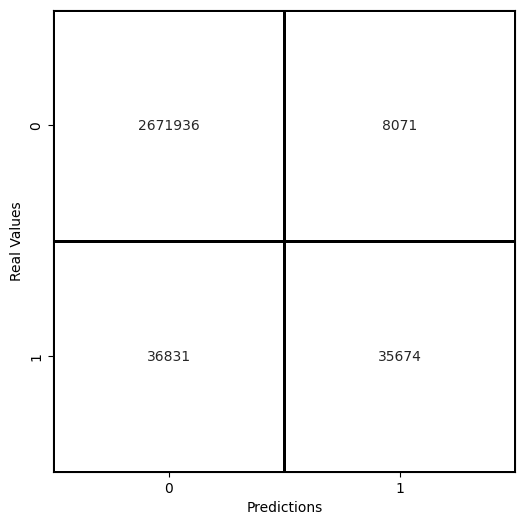

In [ ]:
display_confusion_matrix(y_arr, y_predict_int)

Res-UNet

In [ ]:
# test_ids = list(X_test.image_path)
# test_mask = list(X_test.mask_path)
# test_data = DataGenerator(test_ids, test_mask)
loss, accuracy, jaccard = res_unet_model.evaluate(X_arr, y_arr)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

2/2 [==============================] - 5s 1s/step - loss: 0.0057 - accuracy: 0.9964 - jacard_coef: 0.1400
Loss is 0.57%
Accuracy is 99.64%
Jaccard is 14.00%


In [ ]:
y_predict = res_unet_model.predict(X_arr)

2/2 [==============================] - 1s 633ms/step


In [ ]:
y_predict_int = np.array(y_predict).round().astype(int)

Display Metrics

In [ ]:
display_metrics(y_arr, y_predict_int)

Precision  Recall  Accuracy   Dice   IoU
0      0.923   0.939     0.996  0.931  0.87

Confusion Matrix

TN:  2675486 FP:  4521
FN:  5411 TP:  67094


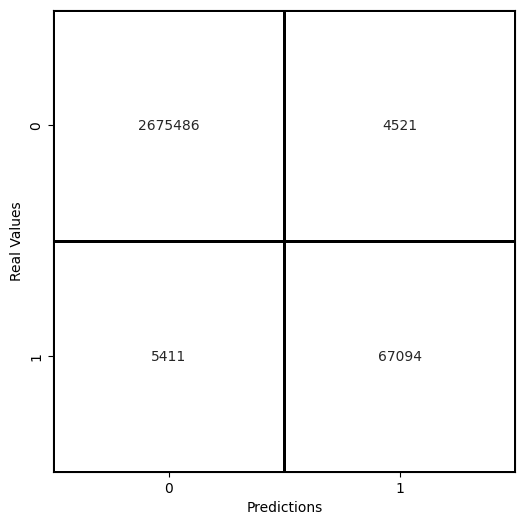

In [ ]:
display_confusion_matrix(y_arr, y_predict_int)

Attention Res-UNet

In [ ]:
# test_ids = list(X_test.image_path)
# test_mask = list(X_test.mask_path)
# test_data = DataGenerator(test_ids, test_mask)
loss, accuracy, jaccard = att_res_unet_model.evaluate(X_arr, y_arr)
print("Loss is {:.2f}%".format(loss*100))
print("Accuracy is {:.2f}%".format(accuracy*100))
print("Jaccard is {:.2f}%".format(jaccard*100))

2/2 [==============================] - 8s 2s/step - loss: 0.0055 - accuracy: 0.9959 - jacard_coef: 0.1472
Loss is 0.55%
Accuracy is 99.59%
Jaccard is 14.72%


In [ ]:
y_predict = att_res_unet_model.predict(X_arr)

2/2 [==============================] - 7s 2s/step


In [ ]:
y_predict_int = np.array(y_predict).round().astype(int)

Display Metrics

In [ ]:
display_metrics(y_arr, y_predict_int)

Precision  Recall  Accuracy   Dice    IoU
0      0.902   0.946     0.996  0.923  0.858

Confusion Matrix

TN:  2673499 FP:  6508
FN:  4634 TP:  67871


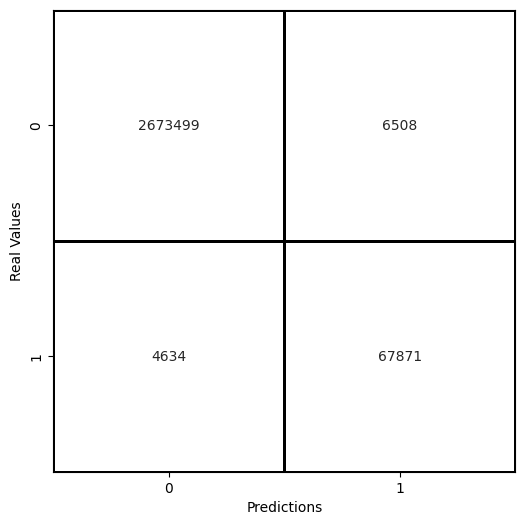

In [ ]:
display_confusion_matrix(y_arr, y_predict_int)

## 9)Visualizing the results

In [ ]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Loop through each row in X_test
for index, row in X_test[:20].iterrows():
    # Load the image
    img_path = row['image_path']
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()

    # Load the original mask
    orig_mask_path = row['mask_path']
    orig_mask = io.imread(orig_mask_path)
    orig_mask = cv2.resize(orig_mask, (256, 256))

    # Create X array for prediction
    X = np.empty((1, 256, 256, 3))
    X[0, ] = img

     # Make prediction of mask
    unet_predict = unet_model.predict(X)
    unet_pred_mask = np.array(unet_predict).squeeze().round()

    res_unet_predict = res_unet_model.predict(X)
    res_unet_pred_mask = np.array(res_unet_predict).squeeze().round()

    att_res_unet_predict = att_res_unet_model.predict(X)
    att_res_unet_pred_mask = np.array(att_res_unet_predict).squeeze().round()

    # Plotting the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(orig_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(unet_pred_mask, cmap='gray')
    plt.title('Unet Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(res_unet_pred_mask, cmap='gray')
    plt.title('Res-Unet Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(att_res_unet_pred_mask, cmap='gray')
    plt.title('Att Res-Unet Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Loop through each row in X_test
for index, row in X_test[:-20].iterrows():
    # Load the image
    img_path = row['image_path']
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()

    # Load the original mask
    orig_mask_path = row['mask_path']
    orig_mask = io.imread(orig_mask_path)
    orig_mask = cv2.resize(orig_mask, (256, 256))

    # Create X array for prediction
    X = np.empty((1, 256, 256, 3))
    X[0, ] = img

    # Make prediction of mask
    predict = unet_model.predict(X)
    pred_mask = np.array(predict).squeeze().round()

    # Plotting the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(orig_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(img)
    plt.imshow(orig_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(img)
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### Res-UNET

In [ ]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Loop through each row in X_test
for index, row in X_test[:20].iterrows():
    # Load the image
    img_path = row['image_path']
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()

    # Load the original mask
    orig_mask_path = row['mask_path']
    orig_mask = io.imread(orig_mask_path)
    orig_mask = cv2.resize(orig_mask, (256, 256))

    # Create X array for prediction
    X = np.empty((1, 256, 256, 3))
    X[0, ] = img

    # Make prediction of mask
    predict = res_unet_model.predict(X)
    pred_mask = np.array(predict).squeeze().round()

    # Plotting the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(orig_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(img)
    plt.imshow(orig_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(img)
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Loop through each row in X_test
for index, row in X_test[:20].iterrows():
    # Load the image
    img_path = row['image_path']
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()

    # Load the original mask
    orig_mask_path = row['mask_path']
    orig_mask = io.imread(orig_mask_path)
    orig_mask = cv2.resize(orig_mask, (256, 256))

    # Create X array for prediction
    X = np.empty((1, 256, 256, 3))
    X[0, ] = img

    # Make prediction of mask
    predict = att_res_unet_model.predict(X)
    pred_mask = np.array(predict).squeeze().round()

    # Plotting the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(orig_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(img)
    plt.imshow(orig_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Original Mask')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(img)
    plt.imshow(pred_mask, alpha=0.5, cmap='jet')
    plt.title('Image with Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.